In [ ]:
# Data
import pandas as pd
import numpy as np
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')

# Modeling
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Evaluation
from sklearn.metrics import silhouette_score

#Scaling
from sklearn.preprocessing import StandardScaler

# Regular Expression
import re

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Import Dataset 
df = pd.read_csv('data_outlist_clean.csv', parse_dates = ['order_purchase_timestamp'] )

df

,order_id,order_purchase_timestamp,order_item_id,product_id,price,freight_value,product_photos_qty,payment_sequential,payment_type,payment_value,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english,month_order,weekday_order,month_year_order,date_order
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16,1.0,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,1.0,1.0,credit_card,146.87,4.0,861eff4711a542e4b93843c6dd7febb0,14409.0,franca,SP,office_furniture,May,Tuesday,2017-05,16.0
1,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19,1.0,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,1.0,1.0,credit_card,157.73,5.0,060e732b5b29e8181a18229c7b0b2b5e,1151.0,sao paulo,SP,office_furniture,May,Saturday,2018-05,19.0
2,951670f92359f4fe4a63112aa7306eba,2018-03-13,1.0,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,1.0,1.0,credit_card,173.30,5.0,259dac757896d24d7702b9acbbff3f3c,8775.0,mogi das cruzes,SP,office_furniture,March,Tuesday,2018-03,13.0
3,997fd4b37386d10b57d4ac8cdec011a6,2018-07-08,1.0,8ed094bfe076c568f6bb10feada3f75d,199.98,115.77,1.0,1.0,credit_card,315.75,1.0,07d190f123147d9e89d4b922543d7948,65075.0,sao luis,MA,office_furniture,July,Sunday,2018-07,8.0
4,b63fff1ef8b6201df68bb611ee41129e,2017-04-02,1.0,aba86c093ccdbac75b09111d57e50004,129.60,16.61,1.0,1.0,boleto,146.21,4.0,332cf4e83e16004ba7dca932ce82475b,90010.0,porto alegre,RS,office_furniture,April,Sunday,2017-04,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4903,9a9fda5708990832a3a7c4e9114de0b0,2018-02-11,1.0,750dcfda0a9788bba89c94bb82a322db,22.99,13.37,1.0,1.0,credit_card,36.36,3.0,6afbf8b1d0c7c75becfa17aaa5d91e96,13295.0,itupeva,SP,housewares,February,Sunday,2018-02,11.0
4904,11660e2c0590a8f36299b868f3e95bed,2018-03-02,1.0,48e146e09757f4c6bc13be2f96dd0ec5,9.99,15.10,1.0,1.0,voucher,25.09,3.0,09543baeee512af0163b09e9d08e8dce,37002.0,varginha,MG,housewares,March,Friday,2018-03,2.0
4905,4dd08fa7dea495346c25580cf491fd79,2018-08-09,1.0,aef98ce647739e381bae28e004c63235,40.00,15.38,4.0,1.0,boleto,55.38,5.0,e3a838bd588ac1fdd5cb746c5ff1753c,13104.0,campinas,SP,housewares,August,Thursday,2018-08,9.0
4906,a7c6365fed8c291cfac8b74f173b7a4f,2018-07-24,1.0,1d974de82e60d653a2d1cc79984dcec8,40.99,11.31,5.0,1.0,boleto,52.30,4.0,6eb59f7b1132420bbca105d1fd5f74df,8311.0,sao paulo,SP,housewares,July,Tuesday,2018-07,24.0


In [ ]:
#Max time
max_time = df['order_purchase_timestamp'].max() + dt.timedelta(1)

#Groupby customer_unique_id
customer = df.groupby('customer_unique_id', as_index=False).agg(
    recency =  ('order_purchase_timestamp', lambda x: (max_time-x.max()).days),
    frequency = ('order_id', lambda x: x.nunique()),
    monetary =  ('payment_value', 'sum'),
    avg_spend = ('payment_value', 'mean'),
    most_payment_type = ('payment_type', lambda x: x.value_counts().index[0]),
    avg_review_score = ('review_score', 'mean'),
    most_product_buy = ('product_category_name_english', lambda x: x.value_counts().index[0]),
    first_transaction = ('month_year_order', 'min')
)

In [ ]:
customer.head()

,customer_unique_id,recency,frequency,monetary,avg_spend,most_payment_type,avg_review_score,most_product_buy,first_transaction
0,0019da6aa6bcb27cc32f1249bd12da05,199,1,87.71,87.710,credit_card,1.0,housewares,2018-02
1,001a34eb30ecb8e3aacb07c475ca4dd1,49,1,161.71,161.710,credit_card,5.0,housewares,2018-07
2,001f3c4211216384d5fe59b041ce1461,528,1,35.84,35.840,credit_card,3.0,housewares,2017-03
3,002043098f10ba39a4600b6c52fbfe3c,521,1,237.81,237.810,credit_card,4.0,office_furniture,2017-03
4,0028a7d8db7b0247652509358ad8d755,259,1,354.87,177.435,credit_card,3.0,office_furniture,2017-12


In [ ]:
print(' data customer :' ,customer['customer_unique_id'].nunique())

 data customer : 3772


# **Recency**

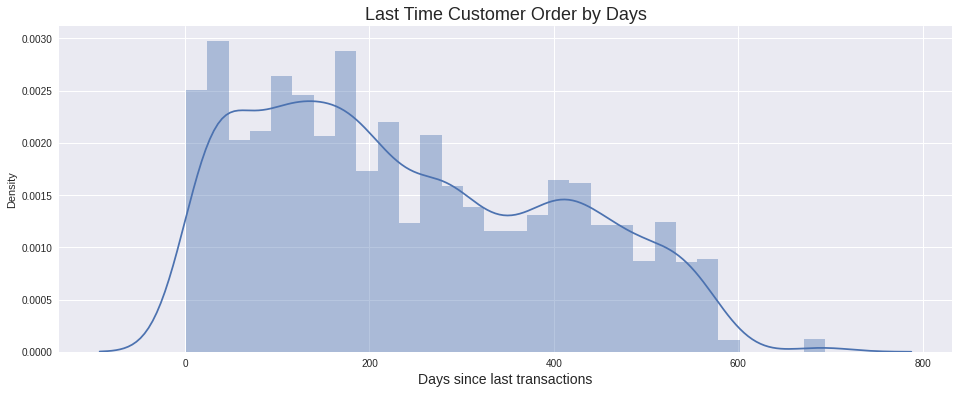

In [ ]:
# Distribution of recency
plt.figure(figsize=(16, 6))
sns.distplot(customer['recency'], bins=30)
plt.title('Last Time Customer Order by Days', fontsize=18)
plt.xlabel('Days since last transactions', fontsize=14)
plt.show()

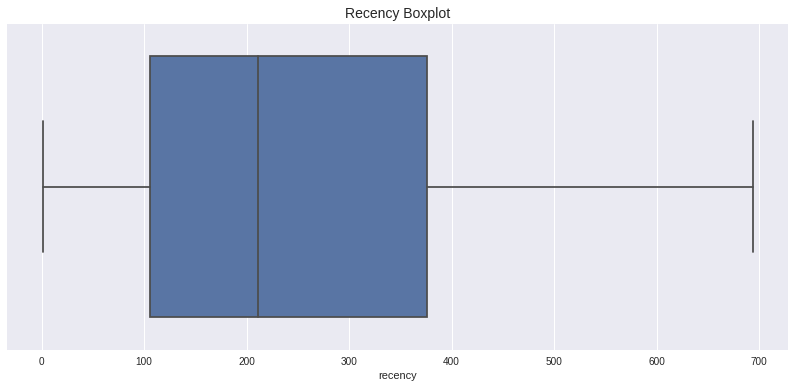

In [ ]:
# Recency Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(customer['recency'])
plt.title('Recency Boxplot', fontsize=14)
plt.show()

In [ ]:
customer['recency'].describe()

count    3772.000000
mean      240.455992
std       162.083438
min         1.000000
25%       106.000000
50%       211.000000
75%       376.000000
max       694.000000
Name: recency, dtype: float64

# **Frequency**

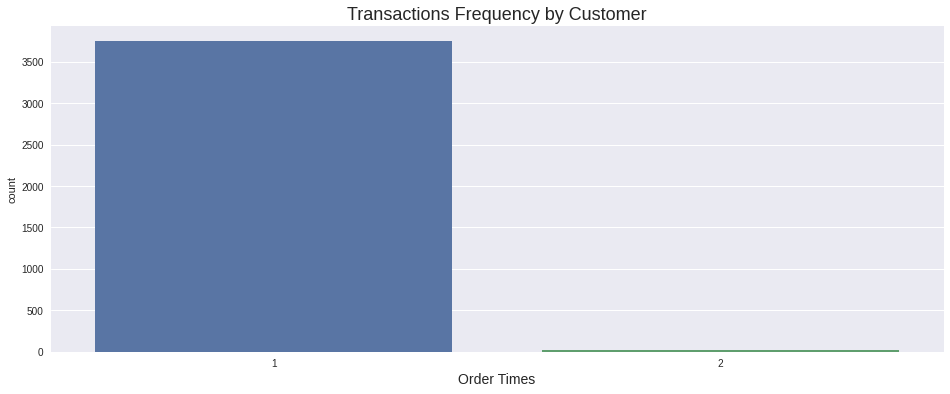

In [ ]:
# Distribution frequency
plt.figure(figsize=(16, 6))
sns.countplot(customer['frequency'])
plt.title('Transactions Frequency by Customer', fontsize=18)
plt.xlabel('Order Times', fontsize=14)
plt.show()

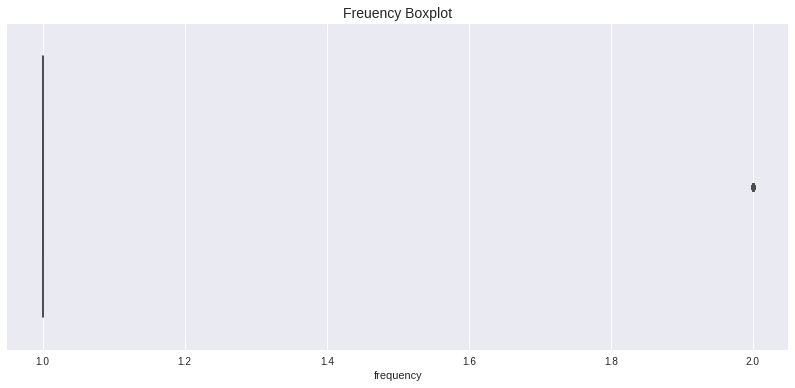

In [ ]:
# Frequency Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(customer['frequency'])
plt.title('Freuency Boxplot', fontsize=14)
plt.show()

In [ ]:
customer['frequency'].describe()

count    3772.000000
mean        1.006363
std         0.079523
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: frequency, dtype: float64

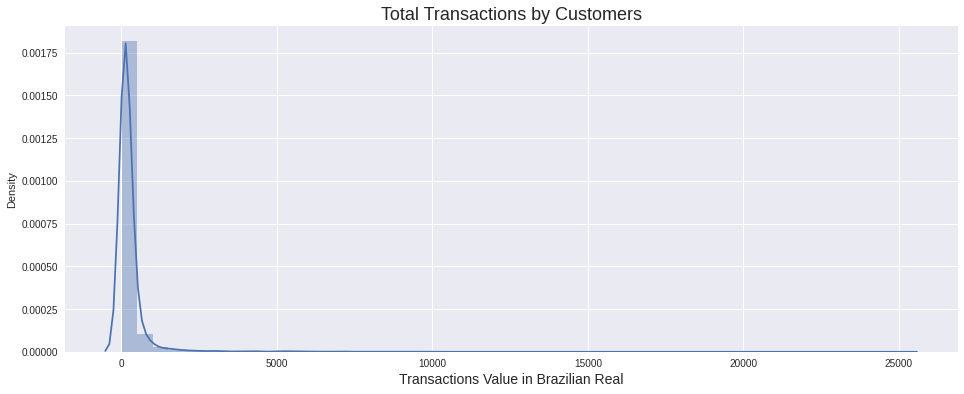

In [ ]:
# Distribusi monetary
plt.figure(figsize=(16, 6))
sns.distplot(customer['monetary'])
plt.title('Total Transactions by Customers', fontsize=18)
plt.xlabel('Transactions Value in Brazilian Real', fontsize=14)
plt.show()

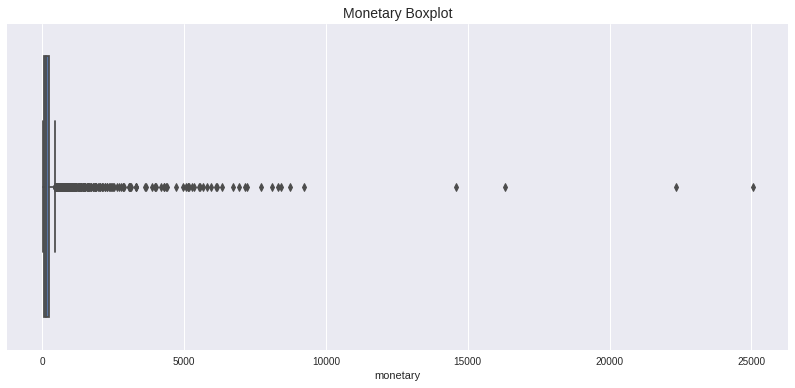

In [ ]:
# Monetary Boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(customer['monetary'])
plt.title('Monetary Boxplot', fontsize=14)
plt.show()

In [ ]:
customer['monetary'].describe()

count     3772.000000
mean       297.139920
std        911.731146
min         14.380000
25%         71.872500
50%        143.380000
75%        228.700000
max      25051.890000
Name: monetary, dtype: float64

In [ ]:

cust_df = pd.read_csv('customer.csv')

In [ ]:
cust_df.head()

,customer_unique_id,recency,frequency,monetary,avg_spend,most_payment_type,avg_review_score,most_product_buy,first_transaction
0,0000366f3b9a7992bf8c76cfdf3221e2,117,1,141.90,141.90,credit_card,5.0,bed_bath_table,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120,1,27.19,27.19,credit_card,4.0,health_beauty,2018-05
2,0000f46a3911fa3c0805444483337064,543,1,86.22,86.22,credit_card,3.0,stationery,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,327,1,43.62,43.62,credit_card,4.0,telephony,2017-10
4,0004aac84e0df4da2b147fca70cf8255,294,1,196.89,196.89,credit_card,5.0,telephony,2017-11


In [ ]:
# Calculate Q1, Q2, Q3 from Recency
(cust_df['recency'].quantile([0.25, 0.5, 0.75])).astype(int)

0.25    120
0.50    224
0.75    354
Name: recency, dtype: int64

In [ ]:
# Recency Segmentation using quartile and scoring
label_r = range(4, 0, -1)
group_r = pd.qcut(cust_df['recency'], q=4, labels=label_r)
cust_df['R'] = group_r.values

In [ ]:
# Group by R
df_R = cust_df.groupby(['R']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)

# Name the R segment
df_R.loc[df_R['R'] == 4, 'R_group'] = 'active'
df_R.loc[df_R['R'] == 3, 'R_group'] = 'warm'
df_R.loc[df_R['R'] == 2, 'R_group'] = 'cold'
df_R.loc[df_R['R'] == 1, 'R_group'] = 'innactive'

# Calculate the percentage
df_R['R_percent'] = round(df_R['n_customers']/df_R['n_customers'].sum()*100, 2)

df_R

,R,n_customers,R_group,R_percent
0,4,5955,active,25.24
1,3,5866,warm,24.86
2,2,5887,cold,24.95
3,1,5885,innactive,24.94


In [ ]:
recency_cust = cust_df['customer_unique_id'].groupby(cust_df['recency']).count()

# Visualization
fig = go.Figure()
# Create Layout
fig.update_layout(
    title='Recency Segmentation',
    xaxis_title='Days (since last transactions)',
    yaxis_title='Total Customers',
    showlegend=False)
# Plot Area Chart
fig.add_trace(go.Scatter(x=recency_cust.index, 
                         y=recency_cust.values, 
                         fill='tozeroy', 
                         mode='none'))
# Plot Line
fig.add_trace(go.Scatter(x=[120, 120], y=[0,1100], 
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q1 (120 days)'))
fig.add_trace(go.Scatter(x=[224, 224], y=[0,1100], 
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q2 (224 days)'))
fig.add_trace(go.Scatter(x=[353, 353], y=[0,1100], 
                         mode="lines", 
                         marker=dict(size=12, line=dict(width=0.8),color='navy'), 
                         name='Q3 (353 days)'))
# Annotation
fig.add_annotation(x=60, y=1000,
            text="Active: 25.26 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=173, y=1000,
            text="Warm: 24.78 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=290, y=1000,
            text="Cold: 25.04 %",
            showarrow=False,
            yshift=10)

fig.add_annotation(x=450, y=1000,
            text="Inactive:  24.91 %",
            showarrow=False,
            yshift=10)
fig.show()

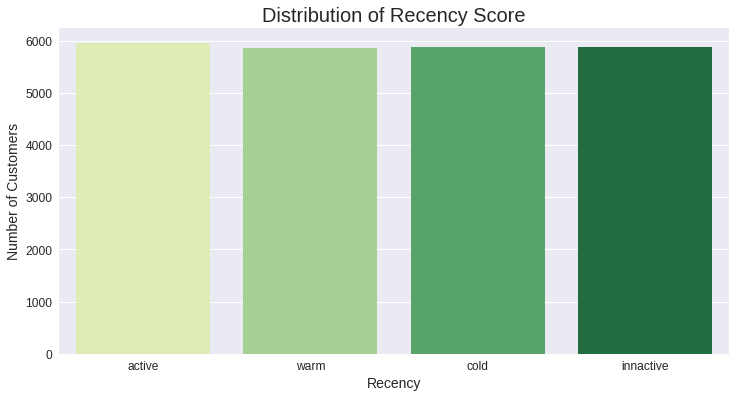

In [ ]:
# Distribution of Recency
plt.figure(figsize=(12, 6))
sns.barplot(x='R_group', y='n_customers', data=df_R, palette='YlGn')
plt.title('Distribution of Recency Score',fontsize=20)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Frequency segmentation
def F_segmentation(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4

cust_df['F'] = cust_df['frequency'].apply(F_segmentation)
cust_df['F'].value_counts()

1    22892
2      654
3       37
4       10
Name: F, dtype: int64

In [ ]:
# Group by F
df_F = cust_df.groupby(['F']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)

# Name the F segmentation
df_F.loc[df_F['F'] == 4, 'F_group'] = 'special'
df_F.loc[df_F['F'] == 3, 'F_group'] = 'high'
df_F.loc[df_F['F'] == 2, 'F_group'] = 'medium'
df_F.loc[df_F['F'] == 1, 'F_group'] = 'low'

# Calculate the percentage
df_F['F_percent'] = round(df_F['n_customers']/df_F['n_customers'].sum()*100, 2)

df_F

,F,n_customers,F_group,F_percent
0,1,22892,low,97.03
1,2,654,medium,2.77
2,3,37,high,0.16
3,4,10,special,0.04


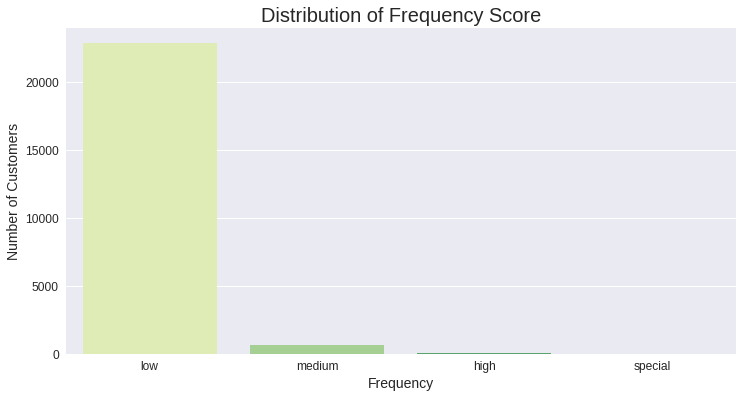

In [ ]:
# Distribution of Frquency
plt.figure(figsize=(12, 6))
sns.barplot(x='F_group', y='n_customers', data=df_F, palette='YlGn')
plt.title('Distribution of Frequency Score',fontsize=20)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Calculate Q1, Q2, Q3 from Monetary
round(cust_df['monetary'].quantile([0.25, 0.5, 0.75]))

0.25     64.0
0.50    114.0
0.75    203.0
Name: monetary, dtype: float64

In [ ]:
# Scoring for M values
labels_m = range(1, 5)
group_m = pd.qcut(cust_df['monetary'], q = 4, labels = labels_m)
cust_df['M'] = group_m.values

In [ ]:
# Group by M
df_M = cust_df.groupby(['M']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index(drop = False)

# Name the M Segmentation
df_M.loc[df_M['M'] == 1, 'M_group'] = 'low values'
df_M.loc[df_M['M'] == 2, 'M_group'] = 'medium values'
df_M.loc[df_M['M'] == 3, 'M_group'] = 'high values'
df_M.loc[df_M['M'] == 4, 'M_group'] = 'special values'

# Calculate the percentage
df_M['M_percent'] = round(df_M['n_customers']/df_M['n_customers'].sum()*100, 2)
df_M

,M,n_customers,M_group,M_percent
0,1,5907,low values,25.04
1,2,5892,medium values,24.97
2,3,5896,high values,24.99
3,4,5898,special values,25.00


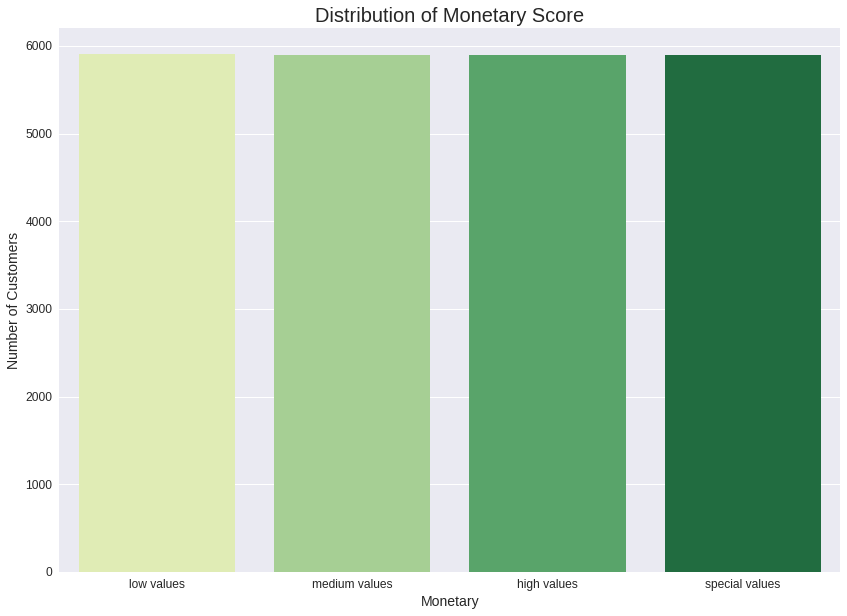

In [ ]:
# Distribution of Monetary
plt.figure(figsize=(14, 10))
sns.barplot(x='M_group', y='n_customers', data=df_M, palette='YlGn')
plt.title('Distribution of Monetary Score',fontsize=20)
plt.xlabel('Monetary',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# **RFM**

In [ ]:
# Combine the R, F, and M score
cust_df['RFM Score'] = cust_df['R'].astype(str) + cust_df['F'].astype(str) + cust_df['M'].astype(str)
cust_df['RFM Score']

0        413
1        411
2        112
3        211
4        213
        ... 
23588    213
23589    311
23590    313
23591    311
23592    114
Name: RFM Score, Length: 23593, dtype: object

In [ ]:
# RFM Segmentation 
def segmentation(x):
    if re.search('444', x) or re.search('344', x): 
        return 'Best'
    elif re.search('2.4', x) or re.search('3.4', x) or re.search('4.4', x):
        return 'Big Spender'
    elif re.search('24.', x) or re.search('34.', x) or re.search('23.', x) or re.search('33.', x):
        return 'Loyal'
    elif re.search('41.', x):
        return 'New'
    elif re.search('4..', x) or re.search('3..', x):
        return 'Promising'
    elif re.search('111', x) or re.search('211', x) or re.search('112', x) or re.search('212', x):
        return 'Lost'
    elif re.search('1..', x) or re.search('2..', x):
        return 'Lost Potential'
    else:
        return 'Reguler'

cust_df['RFM Segment'] = cust_df['RFM Score'].apply(segmentation)
cust_df['RFM Segment'].value_counts()

Lost              5896
Promising         4515
Big Spender       4432
Lost Potential    4382
New               4355
Best                 8
Loyal                5
Name: RFM Segment, dtype: int64

In [ ]:
# Customer Segmentation Percentage
round(cust_df['RFM Segment'].value_counts(normalize=True)*100, 2)

Lost              24.99
Promising         19.14
Big Spender       18.79
Lost Potential    18.57
New               18.46
Best               0.03
Loyal              0.02
Name: RFM Segment, dtype: float64

In [ ]:
rfm_agg = cust_df.groupby('RFM Segment').agg({
    'recency' : 'mean',
    'frequency' : 'mean',
    'monetary' : 'mean',
    'RFM Segment' : 'count'
})

rfm_agg.round(2)

,recency,frequency,monetary,RFM Segment
RFM Segment,,,,
Best,113.88,5.12,1430.38,8
Big Spender,173.09,1.08,592.96,4432
Lost,370.90,1.00,65.17,5896
Lost Potential,402.21,1.05,287.49,4382
Loyal,232.00,3.00,162.49,5
New,63.64,1.00,94.75,4355
Promising,170.76,1.03,95.22,4515


# **Distribution**

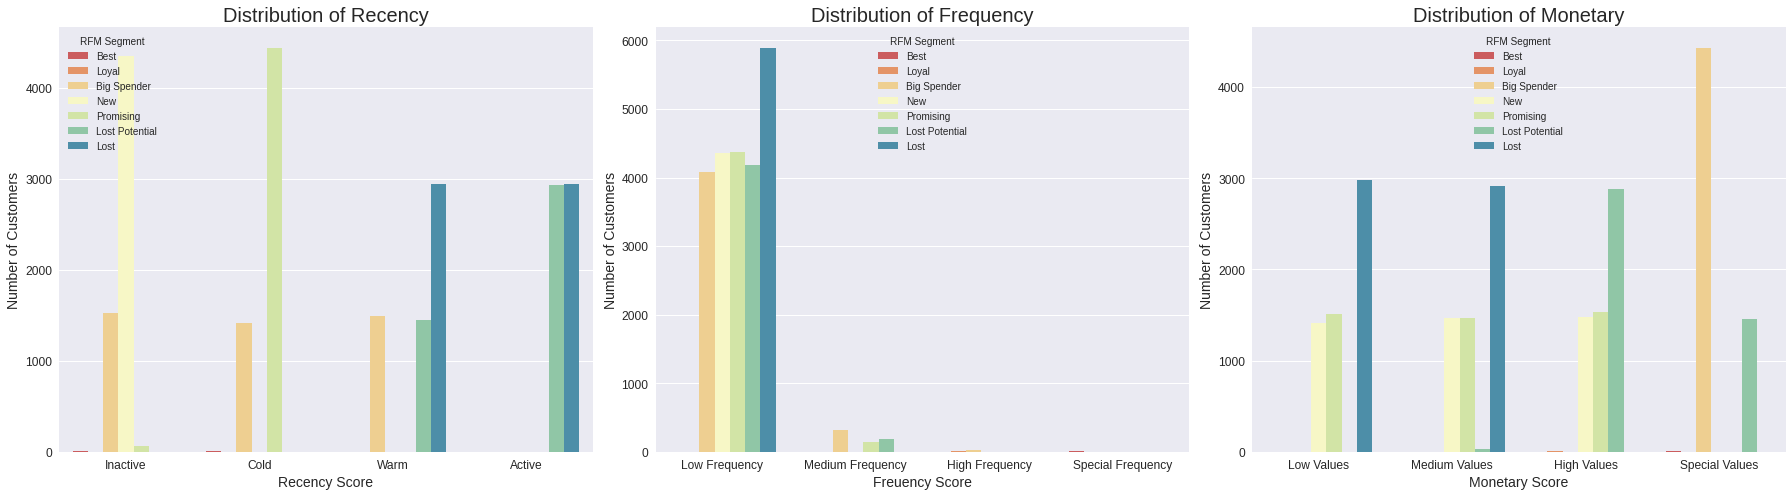

In [ ]:
segment = ['Best', 'Loyal', 'Big Spender', 'New', 'Promising', 'Lost Potential', 'Lost']
# Visualization for Recency, Freuency, Monetary score distribution by Customer Segmentation 2
plt.figure(figsize=(25, 7))

plt.subplot(131)
sns.countplot(x='R', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Recency',fontsize=20)
plt.xlabel('Recency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Inactive', 'Cold', 'Warm', 'Active'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(132)
sns.countplot(x='F', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Frequency',fontsize=20)
plt.xlabel('Freuency Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Frequency', 'Medium Frequency', 'High Frequency', 'Special Frequency'], fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(133)
sns.countplot(x='M', hue='RFM Segment', data=cust_df, hue_order=segment, palette='Spectral')
plt.title('Distribution of Monetary',fontsize=20)
plt.xlabel('Monetary Score',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(np.arange(4), ['Low Values', 'Medium Values', 'High Values', 'Special Values'], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

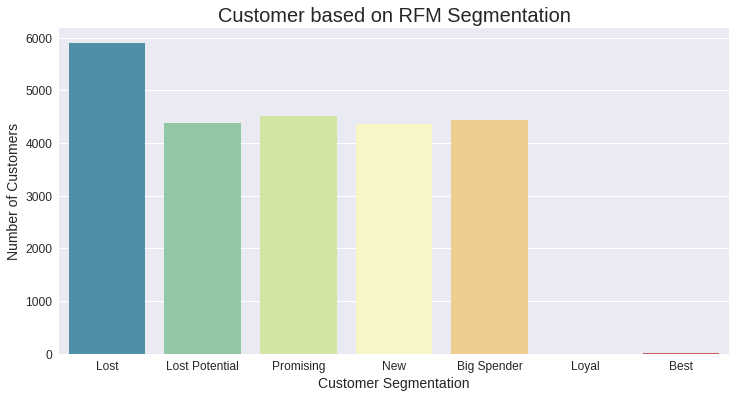

In [ ]:
segment2 = ['Lost', 'Lost Potential', 'Promising', 'New', 'Big Spender', 'Loyal', 'Best']
# Distribution of Customer Segmentation
plt.figure(figsize=(12,6))
sns.countplot(x='RFM Segment', data=cust_df, order=segment2, palette='Spectral_r')
plt.title('Customer based on RFM Segmentation',fontsize=20)
plt.xlabel('Customer Segmentation',fontsize=14)
plt.ylabel('Number of Customers',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


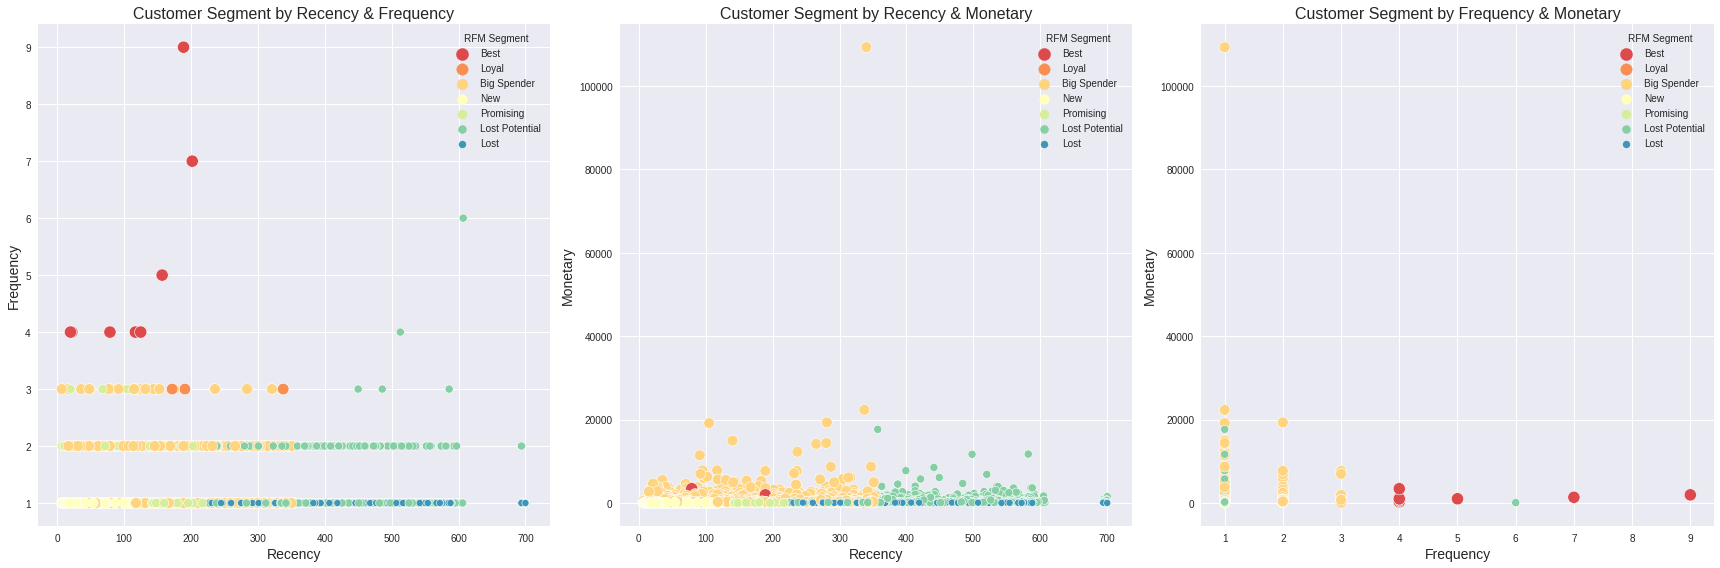

In [ ]:
# Scatter Plot for RFM segmentation 2
plt.figure(figsize=(24,8), facecolor='w')

plt.subplot(131)
sns.scatterplot(x='recency', 
                y='frequency', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment, 
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Frequency',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(132)
sns.scatterplot(x='recency', 
                y='monetary', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment, 
                palette='Spectral')
plt.title('Customer Segment by Recency & Monetary',fontsize=16)
plt.xlabel('Recency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(133)
sns.scatterplot(x='frequency', 
                y='monetary', 
                hue='RFM Segment', 
                data=cust_df, 
                size='RFM Segment', 
                sizes=(50,150), 
                size_order=segment,
                hue_order=segment,
                palette='Spectral')
plt.title('Customer Segment by Frequency & Monetary',fontsize=16)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Monetary',fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
def RFM_segmentation_score(x):
    if x == 'Best':
        return 7
    elif x == 'Loyal':
        return 6
    elif x == 'Big Spender':
        return 5
    elif x == 'New':
        return 4
    elif x == 'Promising':
        return 3
    elif x == 'Lost Potential':
        return 2
    else:
        return 1

cust_df['RFM Segment Score'] = cust_df['RFM Segment'].apply(RFM_segmentation_score)

In [ ]:
fig = px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'RFM Segment')
fig.show()

In [ ]:
# Define x
x = cust_df[['recency', 'frequency', 'monetary']]
# Scale
scaler = StandardScaler()
# Data Scale
x_scaled = scaler.fit_transform(x)
# Calculate Silhoutte Score
labels = cust_df['RFM Segment Score']
silhoutte_value = silhouette_score(x_scaled, labels)
print('Silhoutte Score for RFM:', silhoutte_value)

Silhoutte Score for RFM: 0.10566572851049388


# **K-Means:**

In [ ]:
## Data
x = cust_df[['recency', 'frequency', 'monetary']]

# Scale
scaler = StandardScaler()

# Data Scale
x_scaled = scaler.fit_transform(x)

In [ ]:
score = []
number_of_clusters = range(2,9)

for i in number_of_clusters:
  kmeans = KMeans(i)
  kmeans.fit(x_scaled)

  label = kmeans.labels_
  score.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

In [ ]:
for i in range(len(score)):
  print(f'Silhoutte Score untuk {i+2} Cluster', round(score[i], 3))

Silhoutte Score untuk 2 Cluster 0.783
Silhoutte Score untuk 3 Cluster 0.548
Silhoutte Score untuk 4 Cluster 0.549
Silhoutte Score untuk 5 Cluster 0.555
Silhoutte Score untuk 6 Cluster 0.507
Silhoutte Score untuk 7 Cluster 0.508
Silhoutte Score untuk 8 Cluster 0.521


Text(0, 0.5, 'Silhoutte Score')

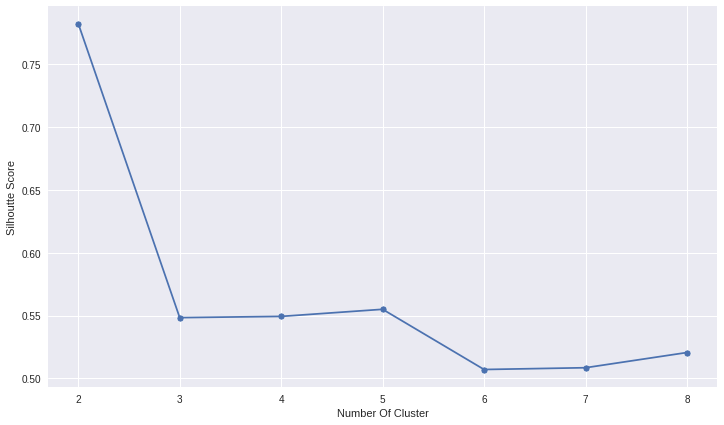

In [ ]:
plt.figure(figsize = (12, 7))

sns.lineplot(number_of_clusters, score)
sns.scatterplot(number_of_clusters, score)

plt.xlabel("Number Of Cluster")
plt.ylabel('Silhoutte Score')

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=10)
kmeans.fit(x_scaled)

cust_df['label k-means'] = kmeans.labels_

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label k-means')

In [ ]:
label = cust_df['label k-means']
score = silhouette_score(x_scaled, label, metric = 'euclidean')
score

0.5550201088394675

In [ ]:
def label(x):
  if x == 0:
    return 'New Comer'
  elif x == 1:
    return 'Lost'
  elif x == 2:
    return 'Big Spender'
  elif x == 3:
    return 'Medium Spender'
  else:
    return 'Loyal'

cust_df['label k-means'] = cust_df['label k-means'].apply(label)

In [ ]:
cust_df['label k-means'].value_counts()

New Comer         13145
Lost               9704
Big Spender         696
Loyal                47
Medium Spender        1
Name: label k-means, dtype: int64

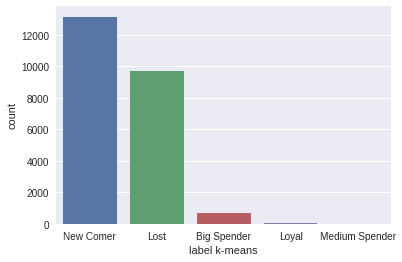

In [ ]:
plt.figure(figsize = (6,4))
sns.countplot(x='label k-means', data = cust_df)
plt.show()

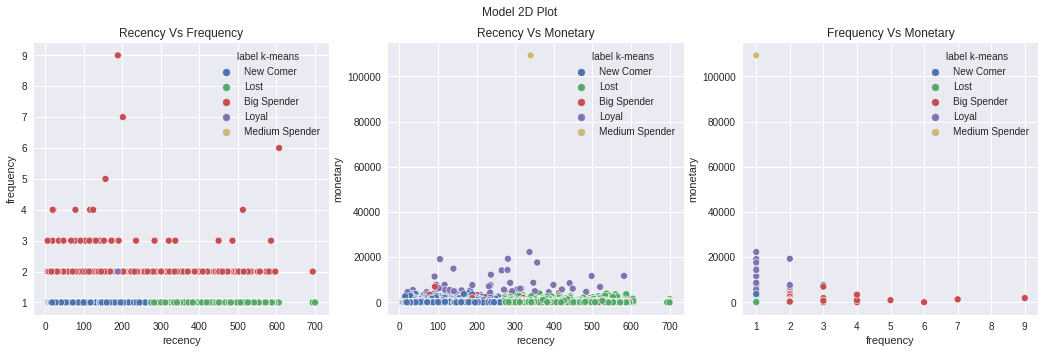

In [ ]:
plt.figure(figsize =(18,5))
# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'label k-means', data = cust_df)
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'label k-means', data = cust_df)
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'label k-means', data = cust_df)
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.show()

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label k-means')


# **Gaussian**

In [ ]:
x = cust_df[['recency', 'frequency', 'monetary']]

In [ ]:
score2 = []
number_of_clusters = range(2,9)

for i in number_of_clusters:
  gsm = GaussianMixture(n_components=i)
  gsm.fit(x)

  label = gsm.predict(x)
  score2.append(silhouette_score(x_scaled, label, metric = 'euclidean'))

In [ ]:
for i in range(len(score2)):
  print(f'Silhoutte Score untuk {i+2} Cluster', round(score2[i], 3))

Silhoutte Score untuk 2 Cluster 0.988
Silhoutte Score untuk 3 Cluster 0.67
Silhoutte Score untuk 4 Cluster 0.614
Silhoutte Score untuk 5 Cluster 0.158
Silhoutte Score untuk 6 Cluster 0.075
Silhoutte Score untuk 7 Cluster 0.076
Silhoutte Score untuk 8 Cluster 0.112


Text(0, 0.5, 'Silhoutte Score')

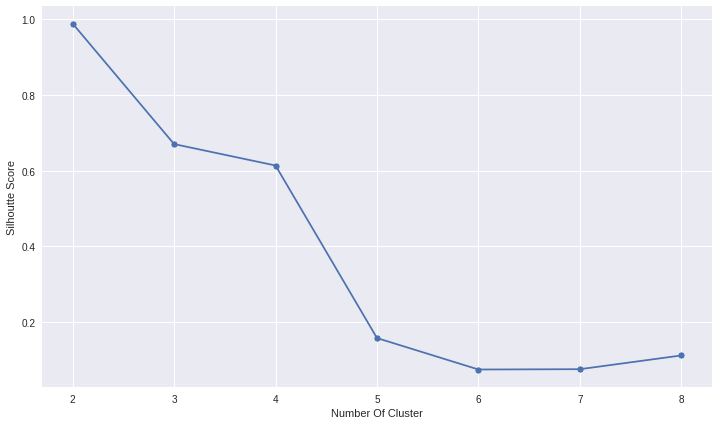

In [ ]:
plt.figure(figsize = (12, 7))

sns.lineplot(number_of_clusters, score2)
sns.scatterplot(number_of_clusters, score2)

plt.xlabel("Number Of Cluster")
plt.ylabel('Silhoutte Score')

In [ ]:
gsm = GaussianMixture(n_components=3)
gsm.fit(x)

cust_df['label gaussian'] = gsm.predict(x)

In [ ]:
px.scatter_3d(cust_df, x = 'recency', y = 'frequency', z = 'monetary', color = 'label gaussian')

In [ ]:
cust_df['label gaussian'].value_counts()

0    22209
2     1383
1        1
Name: label gaussian, dtype: int64

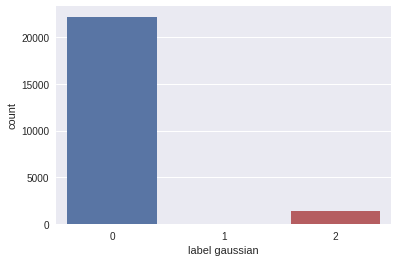

In [ ]:
plt.figure(figsize = (6,4))
sns.countplot(x='label gaussian', data = cust_df)
plt.show()

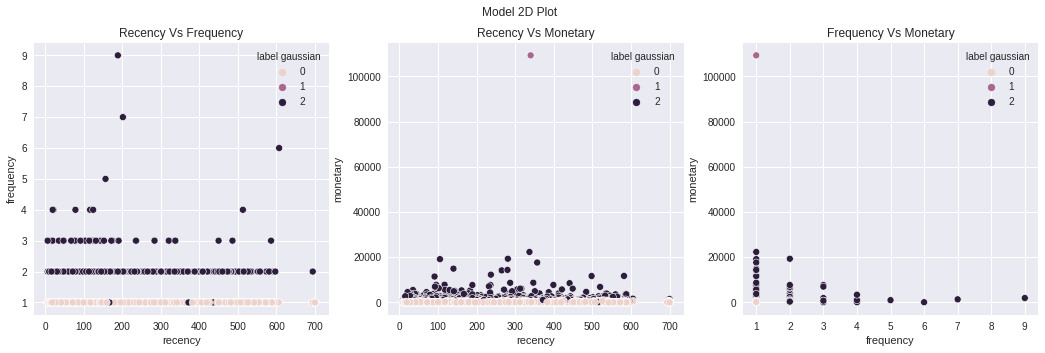

In [ ]:
plt.figure(figsize =(18,5))

# Recency vs Frequency
plt.subplot(131)
sns.scatterplot(x = 'recency', y = 'frequency', hue = 'label gaussian', data = cust_df)
plt.title('Recency Vs Frequency')

# Recency Vs Monetary
plt.subplot(132)
sns.scatterplot(x = 'recency', y = 'monetary', hue = 'label gaussian', data = cust_df)
plt.title('Recency Vs Monetary')

# Frequency Vs Monetary
plt.subplot(133)
sns.scatterplot(x = 'frequency', y = 'monetary', hue = 'label gaussian', data = cust_df)
plt.title('Frequency Vs Monetary')

plt.suptitle('Model 2D Plot')
plt.show()
